In [1]:
!!pip install tensorflow_probability==0.14

['Collecting tensorflow_probability==0.14',
 '  Downloading tensorflow_probability-0.14.0-py2.py3-none-any.whl (5.7 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/5.7 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/5.7 MB\x1b \x1b895.1 kB/s\x1b eta \x1b0:00:07\x1b',
 '\x1b[2K     \x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.1/5.7 MB\x1b \x1b1.2 MB/s\x1b eta \x1b0:00:05\x1b',
 '\x1b[2K     \x1b━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.3/5.7 MB\x1b \x1b2.7 MB/s\x1b eta \x1b0:00:02\x1b',
 '\x1b[2K     \x1b━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.7/5.7 MB\x1b \x1b4.9 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.6/5.7 MB\x1b \x1b8.7 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━\x1b \x1b3.5/5.7 MB\x1b \

# Lab 4 - Social Media Processing

This notebook shows how to use HuggingFace's package to import and train regression models to assess humor rating in social media posts in English (SemEval2021: HaHackathon: Detecting and Rating Humor and Offense https://competitions.codalab.org/competitions/27446, **Task-1b**).

Detection of humour, especially in social media posts, poses a linguistic challenge to NLP, due to the noise, figurative language, contextuality and subjectivity. You will hence try different methods to address those challenges such as preprocessing, data augmentation, ensembling and multi-task learning.

We will download and unzip the data from here: http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip.


We recommend you to do this lab on a Colab TPU provided by Google.

In [2]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip'

--2024-02-28 02:19:25--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip’

hahackathon_data.zi 100%[===================>] 558.21K  1.03MB/s    in 0.5s    

2024-02-28 02:19:26 (1.03 MB/s) - ‘hahackathon_data.zip’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
   creating: hahackathon data/
  inflating: hahackathon data/.DS_Store  
  inflating: __MACOSX/hahackathon data/._.DS_Store  
  inflating: hahackathon data/test.csv  
  inflating: __MACOSX/hahackathon data/._test.csv  
  inflating: hahackathon data/dev.csv  
  inflating: __MACOSX/hahackathon data/._dev.csv  
  inflating: hahackathon data/train.csv  
  inflating: __MACOSX/hahackathon data/._train.csv  


First, we need to install Hugging Face [transformers](https://huggingface.co/transformers/index.html) and [Sentence piece Tokenizers](https://github.com/google/sentencepiece), as well as some helper libraries, with the following commands.

In [3]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [4]:
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.layers import Input, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

We define the fix seed method to be able to introduce variety into ensembling models.

In [5]:
def set_random_seed(seed=123):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed()

## Regression with BERT

We will use the [DistilBert](https://arxiv.org/abs/1910.01108v4) model and its Tokeniser following the preprocessing code from Lab 6.

In [6]:
from transformers import DistilBertTokenizer
import tqdm

# we will pad to 128 subword tokens
PAD_LENGTH = 128
bert = 'distilbert-base-uncased'
BATCH_SIZE = 512
EPOCHS =10

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return (np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32'))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Let's read the data using Pandas.

In [7]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
test_df = test_df.dropna()

Let's check a couple of examples.

In [8]:
train_df

,text,humor_rating,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,2.42,0.20
1,A man inserted an advertisement in the classif...,2.50,1.10
2,How many men does it take to open a can of bee...,1.95,2.40
3,Told my mom I hit 1200 Twitter followers. She ...,2.11,0.00
4,Roses are dead. Love is fake. Weddings are bas...,2.78,0.10
...,...,...,...
7991,"Sins are like viruses, it's better you keep th...",2.13,0.10
7993,My daughter wanted a Cinderella themed birthda...,3.70,0.00
7996,Why are aspirins white? Because they work sorry,1.33,3.85
7997,"Today, we Americans celebrate our independence...",2.55,0.00


In [9]:
# Get the post text
train_examples_list = train_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [10]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  targets = np.array(targets)

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


**Task 1: Build a neural bag of words model using DistilBERT embeddings and the sigmoid activation on the output layer for the regression task.**

Investigate its performance using the Mean Squared Error (MSE) metric. We will use this metric as the loss function as well. We will also use the Adam optimiser with `learning_rate=2e-5`. This code is already provided.

*Hint*: You can reuse the code from Lab 6 on Transfer Learning (Model 2).

In [15]:
from transformers import TFDistilBertModel, DistilBertConfig
import tensorflow as tf


class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask is not None:
            # Casting the mask to float32 to match the data type of `x`
            mask = tf.cast(mask, tf.float32)
            return K.sum(x, axis=1) / K.sum(mask, axis=1, keepdims=True)
        else:
            return super().call(x)

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False

  return TFDistilBertModel.from_pretrained(distil_bert, config = config)

def create_regression_BoW_bert():
    distilBERT = get_BERT_layer()
    input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
    input_masks_ids = Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    # Extracting the sequence output and ignoring the pooled output
    distilBERT_output = distilBERT(input_ids, attention_mask=input_masks_ids)
    sequence_output = distilBERT_output.last_hidden_state

    # Applying the masked global average pooling
    x = GlobalAveragePooling1DMasked()(sequence_output, mask=input_masks_ids)

    # Regression output layer with sigmoid activation
    out_reg = Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])

def get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5):
  if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model on TPU:
    with strategy.scope():
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  elif use_gpu:
    device_name = tf.test.gpu_device_name()
    print(device_name)
    with tf.device('/device:GPU:0'):
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  else:
    model = create_regression_BoW_bert()
    model.compile(optimizer='adam',
                loss='mse',
                metrics=[tf.keras.losses.MeanSquaredError()])
  return model


model = get_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, None, 768),                                                  
                                 hidden_states=None                                         

In [17]:
history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 82s 3s/step - loss: 0.0626 - mean_squared_error: 0.0620
Epoch 2/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0307 - mean_squared_error: 0.0305
Epoch 3/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 4/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0163 - mean_squared_error: 0.0162
Epoch 5/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 7/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0118 - mean_squared_error: 0.0117
Epoch 8/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 9/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 10/10


We evaluate our model on the test set.

In [18]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 9s 134ms/step - loss: 0.0154 - mean_squared_error: 0.0150
Test loss: 0.015424900688230991
Test MSE: 0.01498374156653881


Get the array of predictions here so that you can plot the outputs later.

In [19]:
preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)

preds = np.array(preds).flatten()

20/20 [==============================] - 9s 294ms/step


## Predictive Distribution

We compute min, max and mean for the golden and predicted humour ratings.

In [20]:
min(preds), max(preds), preds.mean()

(0.24266088, 0.66814435, 0.4771863)

In [21]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054000000000000006, 0.6839999999999999, 0.42383414634146344)

<Axes: >

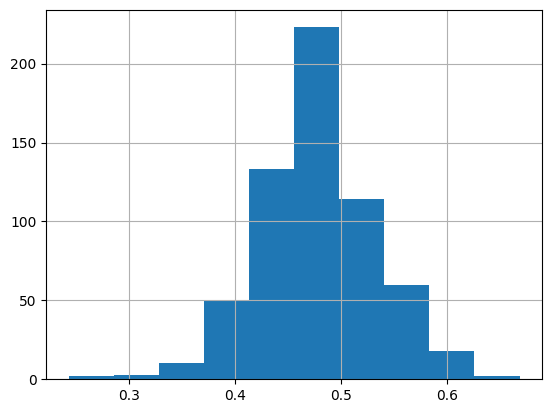

In [22]:
pd.Series(preds).hist()

<Axes: >

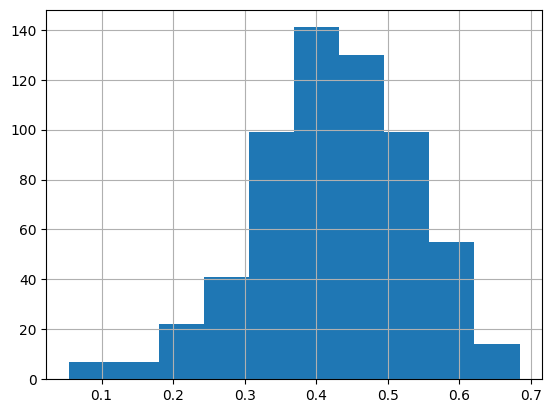

In [23]:
pd.Series(test_targets).hist()

Next, we plot the true vs predicted humour grade for our model.

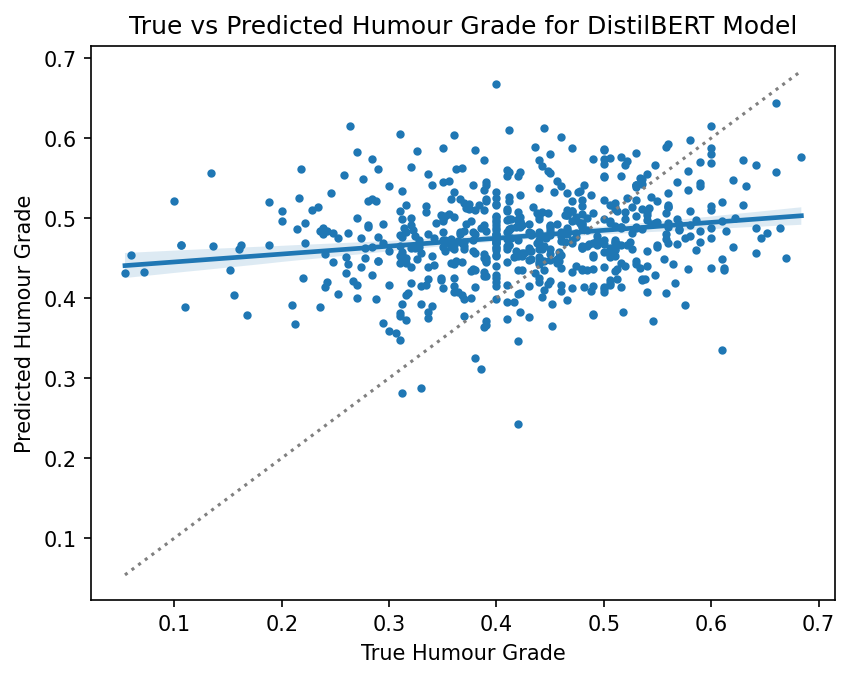

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for DistilBERT Model')

Our regressor tends to smooth down the extreme rating values to make them closer to the mean.

# Feature Engineering & Data Augmentation

**Task 2: Preprocess the textual data with the Ekphrasis library following the standard pipeline https://github.com/cbaziotis/ekphrasis#text-pre-processing-pipeline. How does this affect the performance?**

*Hint*: You might not want to annotate terms in order to keep the same length of the input sentences (for this, do not use the parameter `annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'}`).

In [25]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [28]:
# Your code goes here
from ekphrasis.classes.segmenter import Segmenter
from ekphrasis.classes.spellcorrect import SpellCorrector
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from ekphrasis.classes.preprocessor import TextPreProcessor

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate=[],  # Remove annotations to maintain input sentence length
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # don't spell-correct elongated words

    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text with other expressions
    dicts=[emoticons]
)

new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [29]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: tennessee : we are the best state . nobody even comes close . * elevennessee walks into the room * tennessee : oh shit . . .


In [30]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)

model = get_model()
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 84s 3s/step - loss: 0.0971 - mean_squared_error: 0.0957
Epoch 2/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0351 - mean_squared_error: 0.0348
Epoch 3/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0223 - mean_squared_error: 0.0220
Epoch 4/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 5/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 7/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 8/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0115 - mean_squared_error: 0.0116
Epoch 9/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0112 - mean_squared_error: 0.0111
Epoch 10/10


In [31]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 10s 135ms/step - loss: 0.0141 - mean_squared_error: 0.0138
Test loss: 0.014126833528280258
Test MSE: 0.01384069211781025


Your results may be different depending on the implementation but typically special preprocessing does not drastically change the performance for this task.

**Task 3: Augment the training data twice by changing the original data via two methods from the Nlpaug (https://github.com/makcedward/nlpaug) library: (a) synonym replacement from WordNet; (b) deletion of random words. Comment on which method gives the best performance.**

*Hint*: Use the Synonym Augmenter and Random Word Augmenter (Delete word randomly) classes as follows:
```
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)

aug = naw.RandomWordAug()
augmented_text = aug.augment(text)
```





For more examples check https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [32]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 2.9 MB/s eta 0:00:00


In [39]:
# Get the data again to apply augmentation
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

In [40]:
import nlpaug.augmenter.word as naw

# Your code goes here

# Define augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
random_delete_aug = naw.RandomWordAug()

# Augment data
augmented_data_synonym = [synonym_aug.augment(text) for text in train_examples_list]
augmented_data_deletion = [random_delete_aug.augment(text) for text in train_examples_list]


In [41]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


We have now augmented the original data twice:

In [43]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
4932
Training examples after augmentation:
4932


In [44]:
model = get_model()
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 86s 3s/step - loss: 0.0873 - mean_squared_error: 0.0853
Epoch 2/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0360 - mean_squared_error: 0.0355
Epoch 3/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0231 - mean_squared_error: 0.0229
Epoch 4/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0169 - mean_squared_error: 0.0168
Epoch 5/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 6/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 7/10
10/10 [==============================] - 2s 187ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 8/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 9/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 10/10


In [45]:
results = model.evaluate([np.asarray(test_input_ids),np.asarray(test_attention_masks)], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 9s 137ms/step - loss: 0.0132 - mean_squared_error: 0.0129
Test loss: 0.013210474513471127
Test MSE: 0.012920158915221691


Your results may be different depending on the implementation but typically there are no drastic differences between the augmentation setups.

# Ensembled BERT Model

In this section you will train and evaluate an **ensemble** of BERT models.

We define the hyperparameters, including the number of models we want to ensemble (RERUNS=3, i.e., 3 models).

**Task 4: Train three DistilBERT models, get their predictions on the test set, take the mean of those predictions and evaluate this ensembled prediction. Comment on the resulting performance.**

We create three models in a loop, set a new random seed before creating each of them (`set_random_seed(seed=random.randint(0, 500))`) and accumulate predictions per model in a list.

In [46]:
# Get the train data again to avoid any confusion
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)


In [49]:
RERUNS = 3
# We save the predictions of each model to the list
all_model_preds = list()

for i in range(RERUNS):
    print(f"Training model {i+1}/{RERUNS}")
    tf.random.set_seed(np.random.randint(0, 500))

    model = get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5)

    model.fit([train_input_ids,train_attention_masks],
              train_targets,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=1)

    # Collecting predictions
    preds = model.predict([test_input_ids, test_attention_masks])
    all_model_preds.append(preds)

Training model 1/3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 88s 4s/step - loss: 0.0473 - mean_squared_error: 0.0465
Epoch 2/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0214 - mean_squared_error: 0.0213
Epoch 3/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 4/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 5/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0125 - mean_squared_error: 0.0124
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0119 - mean_squared_error: 0.0120
Epoch 7/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 8/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 9/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0108 - mean_squared_error: 0.0107
Epoch 10/10


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 87s 4s/step - loss: 0.0697 - mean_squared_error: 0.0688
Epoch 2/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0329 - mean_squared_error: 0.0327
Epoch 3/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0214 - mean_squared_error: 0.0212
Epoch 4/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 5/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0129 - mean_squared_error: 0.0130
Epoch 7/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 8/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 9/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 10/10


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 87s 4s/step - loss: 0.0661 - mean_squared_error: 0.0648
Epoch 2/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0308 - mean_squared_error: 0.0307
Epoch 3/10
10/10 [==============================] - 2s 179ms/step - loss: 0.0200 - mean_squared_error: 0.0199
Epoch 4/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0164 - mean_squared_error: 0.0163
Epoch 5/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 6/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 7/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0118 - mean_squared_error: 0.0117
Epoch 8/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 9/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 10/10


In [50]:
from sklearn.metrics import classification_report, mean_squared_error

mean_preds = np.mean(np.array(all_model_preds), axis=0)
ensemble_mse = mean_squared_error(test_targets, mean_preds)

print('Ensemble Test MSE : {:.4f}'.format(ensemble_mse))

Ensemble Test MSE : 0.0130


Your results may be different depending on the implementation but typically ensembling slightly improves the performance for this task.

# Multi-task Learning with BERT

**Task 6: Train a multi-task (MTL) model with the additional regression task of predicting the offense rating. Re-train the single-task model from Task 1 with half of the initial training data. The code to fetch these data is provided below. Comment on the resulting performance for the regresion task in the data sparsity conditions for the two models (single-task and MTL).**

*Hint*: The MTL model will have two identical output layers (one for predicting humour rating, the other to predict offense rating).

We specify two losses and two metrics to compile the model `loss={'out_reg1': 'mse', 'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 'out_reg2': 'mse'}`. We increase the epoch count to 25 due to the reduced training data.

In [51]:
set_random_seed()

from transformers import TFDistilBertModel, DistilBertConfig
from tensorflow.keras.layers import Input, Dense, Dropout

def create_TFBertMultitask():

  # Your code goes here
  config = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states=False)
  distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

  # Inputs
  input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
  input_masks_ids = Input(shape=(None,), dtype=tf.int32, name="attention_mask")

  # BERT embeddings
  distilBERT_output = distilBERT(input_ids, attention_mask=input_masks_ids)
  sequence_output = distilBERT_output.last_hidden_state

  # Shared layers
  x = GlobalAveragePooling1DMasked()(sequence_output)
  x = Dropout(0.1)(x)

  # Task-specific layers
  out_reg1 = Dense(1, activation='sigmoid', name='out_reg1')(x)  # For humor rating prediction
  out_reg2 = Dense(1, activation='sigmoid', name='out_reg2')(x)  # For offense rating prediction


  # comment to run a single-task model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1, out_reg2])
  # uncomment to run a single-task model
  # return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1])

use_tpu = True
use_gpu = False
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # comment to run a single-task model
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse',
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse',
                          'out_reg2': 'mse'})
    # uncomment to run a single-task model
    # model.compile(optimizer=optimizer, loss={'out_reg1': 'mse'}, metrics={'out_reg1': 'mse'})

elif use_gpu:
  device_name = tf.test.gpu_device_name()
  print(device_name)
  with tf.device('/device:GPU:0'):
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse',
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse',
                          'out_reg2': 'mse'})
else:
  model = create_TFBertMultitask()
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  model.compile(optimizer=optimizer, loss={'out_reg1': 'mse',
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse',
                          'out_reg2': 'mse'})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [52]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_distil_bert_model_13 (TFDis  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, None, 768),                                                  
                                 hidden_states=None                                        

In [53]:
# Get half of the training data
train_examples_list = train_df['text'].tolist()[2500:]
train_targets_list = (train_df['humor_rating']/5).tolist()[2500:]

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Get the offense ratings for the second regression task (we normalise them as well)
train_targets2_list = (train_df['offense_rating']/5).tolist()[2500:]
test_targets2_list = (test_df['offense_rating']/5).tolist()

train_targets2 = np.array(train_targets2_list)
test_targets2 = np.array(test_targets2_list)

In [54]:
# comment to run a single-task model

history = model.fit([train_input_ids, train_attention_masks],
                    [train_targets, train_targets2],
                    epochs=25,
                    batch_size=BATCH_SIZE,
                    verbose=1)

# uncomment to run a single-task model
# history = model.fit([train_input_ids, train_attention_masks],
#                    [train_targets],
#                    epochs=25,
#                    batch_size=BATCH_SIZE,
#                    verbose=1)

Epoch 1/25
5/5 [==============================] - 89s 8s/step - loss: 0.0912 - out_reg1_loss: 0.0177 - out_reg2_loss: 0.0735 - out_reg1_mse: 0.0177 - out_reg2_mse: 0.0735
Epoch 2/25
5/5 [==============================] - 1s 192ms/step - loss: 0.0742 - out_reg1_loss: 0.0148 - out_reg2_loss: 0.0594 - out_reg1_mse: 0.0148 - out_reg2_mse: 0.0594
Epoch 3/25
5/5 [==============================] - 1s 197ms/step - loss: 0.0707 - out_reg1_loss: 0.0132 - out_reg2_loss: 0.0575 - out_reg1_mse: 0.0132 - out_reg2_mse: 0.0575
Epoch 4/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0618 - out_reg1_loss: 0.0123 - out_reg2_loss: 0.0495 - out_reg1_mse: 0.0123 - out_reg2_mse: 0.0495
Epoch 5/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0597 - out_reg1_loss: 0.0119 - out_reg2_loss: 0.0478 - out_reg1_mse: 0.0119 - out_reg2_mse: 0.0478
Epoch 6/25
5/5 [==============================] - 1s 192ms/step - loss: 0.0580 - out_reg1_loss: 0.0116 - out_reg2_loss: 0.0464 - out_reg1

In [55]:
results = model.evaluate([test_input_ids,test_attention_masks], [test_targets, test_targets2])
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 10s 152ms/step - loss: 0.0302 - out_reg1_loss: 0.0124 - out_reg2_loss: 0.0178 - out_reg1_mse: 0.0124 - out_reg2_mse: 0.0178
Test loss: 0.030175114050507545
Test MSE: 0.012395760975778103


Your results may be different depending on the implementation but typically MTL slightly improves the performance over the single-task model trained in similar conditions.